<a href="https://colab.research.google.com/github/Michael-Zh/DAassignment4IK/blob/main/DA_assignment_IKEA_V4.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Assignment - IKEA DA

Prepared by **Michael Zhang** | 2021 Mar | @AMSTERDAM

## 0. Executive Summary

### Question 1: Propose a segmentation analysis

A natural thought to segment the consumer is to use `clustering analysis`. With a relatively clean data... Seg A, B, C

### Question 3: Key segment(s) to focus to increase sales

Seg A
based on A, B, C reasons
* Increase sales is more of a short-term goal -> with the info I have, either focus on the large seg with potential to upsell (small improvement but big moneytory potential), or niche seg with great %growth potential

### Question 2: Potential data points to improve the analysis

* Unit info: understand if the product is of high unit price (which may not be purchased again in a short term)
* Category info: similar to above; also make it difficult to interpret the clustering
* Transactional info: what does it buy together per order -> basket analysis, frequency analysis, recency (3D of CLV or CV)


### Question 4: Prediction of the value in "HaveChildren" with vitualization

In [501]:
!pip install kneed

In [502]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 1. Data Import and Exploration
##### **High-level descriptives**
* **Sex**: 70% are Male
* **Age**: 35% are 26-35, followed by ~20% 18-25 and 36-45, respectively
* **CityType**: 50%+ from type C cities
* **YearsInCity**: 35% reside between 1-2 years, followed by 20% 2-3 years (other durations are close too)
* **HaveChildren**: 55% Customers do not have children (and 3.5% of them missing this information)
* **TotalSpending** and **ValueTier**: top 20% customers contribute 55% of the total revenue; next 30% contribute 30%; and the bottom 50% contribute 15%. Accordingly, label them as `High`, `Mid` and `Low` in `ValueTier`
* **PriceTier**: based on the item unit price (less than 5500, 5500 to 10000, and over 10000), classify each item as `High`, `Mid` and `Low` in `PriceTier`

##### **Load raw data and convert to proper data type**

In [503]:
url = 'https://raw.githubusercontent.com/Michael-Zh/DAassignment4IK/main/RetailCustomerSales.csv'

df = pd.read_csv(url,sep = ';', dtype = {'CustomerID':'str',
                                         'ItemID':'str',
                                          'Sex':'str',
                                          'Age':'str',
                                          'Profession':'str',
                                          'CityType':'str',
                                          'YearsInCity':'str',
                                          'HaveChildren':'str',## to deal witht he NaN
                                          'ItemCategory1':'str',
                                          'ItemCategory2':'str',
                                          'ItemCategory3':'str'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CustomerID     537577 non-null  object
 1   ItemID         537577 non-null  object
 2   Sex            537577 non-null  object
 3   Age            537577 non-null  object
 4   Profession     537577 non-null  object
 5   CityType       537577 non-null  object
 6   YearsInCity    537577 non-null  object
 7   HaveChildren   517407 non-null  object
 8   ItemCategory1  537577 non-null  object
 9   ItemCategory2  370591 non-null  object
 10  ItemCategory3  164278 non-null  object
 11  Amount         537577 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 49.2+ MB


##### **Check duplicated rows**

In [504]:
df.duplicated().sum()

0

##### **Check `NaN` value**
* Only `HaveChildren` column has `NaN`

In [505]:
print(df.isnull().sum())

CustomerID            0
ItemID                0
Sex                   0
Age                   0
Profession            0
CityType              0
YearsInCity           0
HaveChildren      20170
ItemCategory1         0
ItemCategory2    166986
ItemCategory3    373299
Amount                0
dtype: int64


##### **Revenue contributions per customer and check potential outliers**

In [506]:
consumer_spend = df.groupby('CustomerID')['Amount'].sum().sort_values()
consumer_spend.describe()

count    5.891000e+03
mean     8.517515e+05
std      9.329978e+05
min      4.410800e+04
25%      2.349140e+05
50%      5.126120e+05
75%      1.099005e+06
max      1.053678e+07
Name: Amount, dtype: float64

In [507]:
consumer_spend.sum()

5017668378

In [508]:
## Top 20% customers contribute 55% of the total revenue
consumer_spend.loc[(consumer_spend>consumer_spend.quantile(0.8)),].sum()/consumer_spend.sum()

0.5543116293206732

In [509]:
## Mid 30% customers contribute 30% of the total revenue
consumer_spend.loc[(consumer_spend<=consumer_spend.quantile(0.8)) & (consumer_spend>consumer_spend.quantile(0.5)),].sum()/consumer_spend.sum()

0.29442580392067513

In [510]:
## Bottom 50% customers contribute 15% of the total revenue
consumer_spend.loc[(consumer_spend<=consumer_spend.quantile(0.5)),].sum()/consumer_spend.sum()

0.15126256675865157

In [511]:
## Check the count of CustomerID in each ValueTier
consumer_spend = pd.DataFrame(consumer_spend)
consumer_spend.loc[consumer_spend['Amount']<consumer_spend['Amount'].quantile(0.5),'ValueTier'] = 'Low'
consumer_spend.loc[(consumer_spend['Amount']>=consumer_spend['Amount'].quantile(0.5))&(consumer_spend['Amount']<consumer_spend['Amount'].quantile(0.8)),'ValueTier'] = 'Mid'
consumer_spend.loc[consumer_spend['Amount']>consumer_spend['Amount'].quantile(0.8),'ValueTier'] = 'High'
consumer_spend['ValueTier'].value_counts()

Low     2945
Mid     1767
High    1178
Name: ValueTier, dtype: int64

The top 3 dots in the box plot can potentially be removed as outlier: `TotalSpending` > 7M

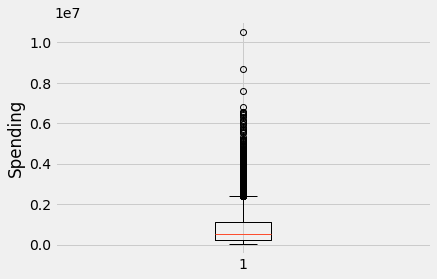

In [322]:
plt.style.use("fivethirtyeight")
plt.boxplot(consumer_spend['Amount'])
plt.ylabel("Spending")
plt.show()

In [323]:
## Check the top 10 amount -> identify the top dots in the box plot
consumer_spend['Amount'].sort_values(ascending=False).head(10)

CustomerID
1004277    10536783
1001680     8699232
1002909     7577505
1001941     6817493
1000424     6573609
1004448     6565878
1001015     6511302
1003391     6476786
1001181     6387899
1000549     6310604
Name: Amount, dtype: int64

In [512]:
## Pull the outliers' CustomerID for later exclusion
consumer_spend_outlier = consumer_spend['Amount'].sort_values(ascending=False).iloc[:3].index.tolist()
consumer_spend_outlier

['1004277', '1001680', '1002909']

##### **Segment items based on their unit price** (assuming each row is a single unit):
* price < 5500 **Low Price**
* 5500<= price <10000 **Mid Price**
* price >10000 **High Price**

In [325]:
item_UnitPrice = df.groupby('ItemID')['Amount'].mean().sort_values()
item_UnitPrice.describe()

count     3623.000000
mean      7885.579323
std       3865.782359
min        405.000000
25%       5391.022321
50%       6943.724138
75%      10138.703652
max      21297.865672
Name: Amount, dtype: float64

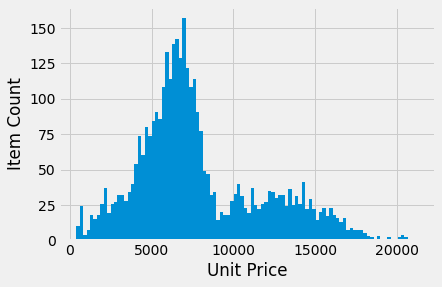

In [326]:
plt.style.use("fivethirtyeight")
plt.hist(item_UnitPrice, bins = 100)
plt.xlabel("Unit Price")
plt.ylabel("Item Count")
plt.show()

In [327]:
item_UnitPriceMap = pd.DataFrame(item_UnitPrice)
item_UnitPriceMap.loc[item_UnitPriceMap['Amount']<5500,'PriceTier'] = 'Low'
item_UnitPriceMap.loc[(item_UnitPriceMap['Amount']>=5500)&(item_UnitPriceMap['Amount']<10000),'PriceTier'] = 'Mid'
item_UnitPriceMap.loc[item_UnitPriceMap['Amount']>=10000,'PriceTier'] = 'High'

In [513]:
## Check the unique ItemID in each price tier
item_UnitPriceMap['PriceTier'].value_counts()

Mid     1744
Low      946
High     933
Name: PriceTier, dtype: int64

##### **Other descriptives**

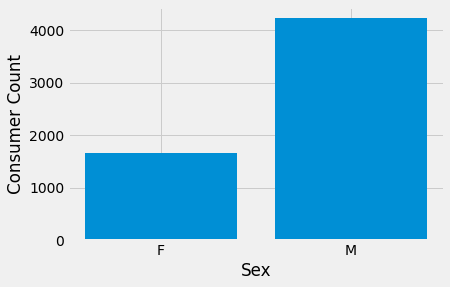

In [329]:
sex = df.groupby('Sex')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(sex.index, sex)
plt.xlabel("Sex")
plt.ylabel("Consumer Count")
plt.show()

In [330]:
round(sex/sex.sum()*100,1)

Sex
F    28.3
M    71.7
Name: CustomerID, dtype: float64

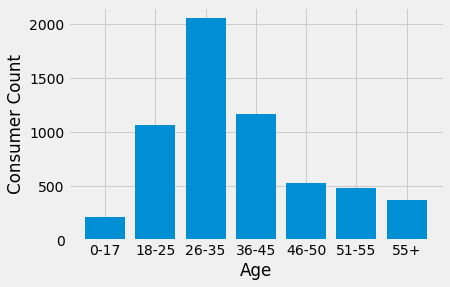

In [331]:
age = df.groupby('Age')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(age.index, age)
plt.xlabel("Age")
plt.ylabel("Consumer Count")
plt.show()

## Main consumer base is aroudn 26-35 YO

In [332]:
round(age/age.sum()*100,1)

Age
0-17      3.7
18-25    18.1
26-35    34.8
36-45    19.8
46-50     9.0
51-55     8.2
55+       6.3
Name: CustomerID, dtype: float64

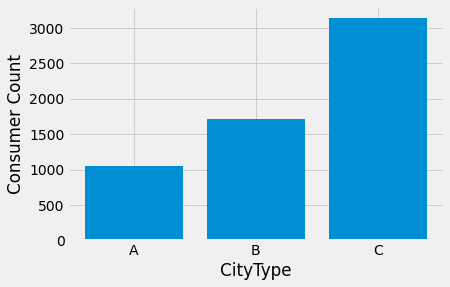

In [333]:
CityType = df.groupby('CityType')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(CityType.index, CityType)
plt.xlabel("CityType")
plt.ylabel("Consumer Count")
plt.show()

In [334]:
round(CityType/CityType.sum()*100,1)

CityType
A    17.7
B    29.0
C    53.3
Name: CustomerID, dtype: float64

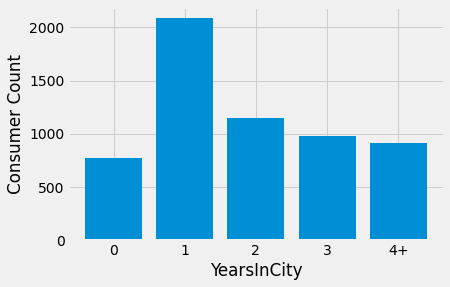

In [335]:
YearsInCity = df.groupby('YearsInCity')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(YearsInCity.index, YearsInCity)
plt.xlabel("YearsInCity")
plt.ylabel("Consumer Count")
plt.show()

In [336]:
round(YearsInCity/YearsInCity.sum()*100,1)

YearsInCity
0     13.1
1     35.4
2     19.4
3     16.6
4+    15.4
Name: CustomerID, dtype: float64

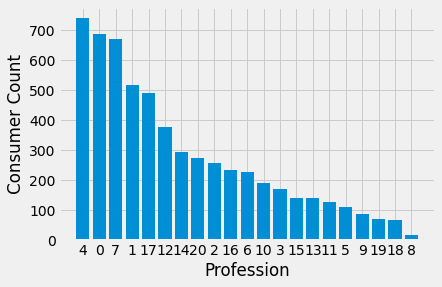

In [337]:
Profession = df.groupby('Profession')['CustomerID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.bar(Profession.index, Profession)
plt.xlabel("Profession")
plt.ylabel("Consumer Count")
plt.show()

In [338]:
round(Profession/Profession.sum()*100,1)

Profession
4     12.6
0     11.7
7     11.4
1      8.8
17     8.3
12     6.4
14     5.0
20     4.6
2      4.3
16     4.0
6      3.9
10     3.3
3      2.9
15     2.4
13     2.4
11     2.2
5      1.9
9      1.5
19     1.2
18     1.1
8      0.3
Name: CustomerID, dtype: float64

Since the missing records account for a small subset (3.6%), consider remove it from the clustering

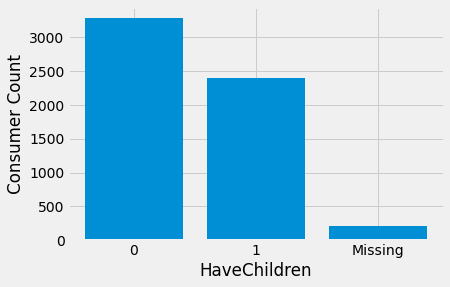

In [339]:
df_c = df.copy()
df_c['HaveChildren'] = df_c['HaveChildren'].fillna('Missing')
HaveChildren = df_c.groupby('HaveChildren')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(HaveChildren.index, HaveChildren)
plt.xlabel("HaveChildren")
plt.ylabel("Consumer Count")
plt.show()

In [340]:
round(HaveChildren/HaveChildren.sum()*100,1)

HaveChildren
0          55.7
1          40.7
Missing     3.6
Name: CustomerID, dtype: float64

###### **Check how the category columns structure**

In [341]:
df.loc[df['ItemCategory1'] == df['ItemCategory2'],'ItemID'].unique()
## cat start small

array([], dtype=object)

##### **Convert the category combination to one column**
Category 5 and 8 has both very high # of unique items and high sales

In [342]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

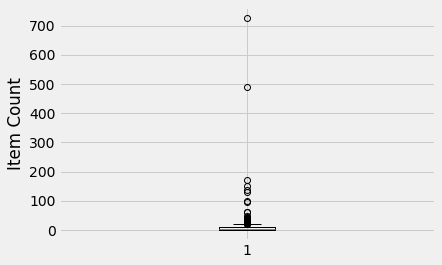

In [343]:
ItemCombo = df_combo.groupby(['CatCombo'])['ItemID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemCombo)
plt.ylabel("Item Count")
plt.show()

In [344]:
ItemCombo.head(5)

CatCombo
8_N_N     727
5_N_N     488
11_N_N    171
5_8_N     150
5_14_N    136
Name: ItemID, dtype: int64

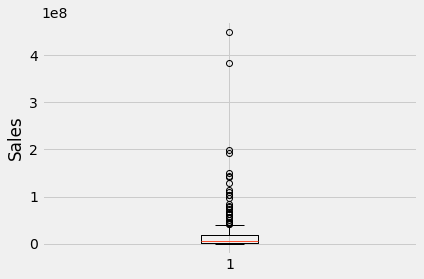

In [345]:
ItemComboSales = df_combo.groupby(['CatCombo'])['Amount'].sum().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemComboSales)
plt.ylabel("Sales")
plt.show()

In [346]:
ItemComboSales.head(5)

CatCombo
8_N_N     449437193
5_N_N     383126455
1_16_N    198147606
1_2_15    191990411
5_8_N     149089678
Name: Amount, dtype: int64

## 2. Segmentation (Clustering Analysis)

#### Considerations of clustering model/feature selection
* To serve the main business goal, which is (short-term) sales growth, in this assignment I use the classic and popular `K-means` clustering method to cluster the (simplified) purchasing behavior, as all the features are conintuous data.

* Feature selection/creation: from the initial exploration, three `ValueTiers` are apparent. However, even if we go after the high value members, what drives them to buy more (or will they at all)? Therefore, I constructed a set of features representing the percentage of spend in each `PriceTier` of a consumer's `TotalSpending`. E.g. a high value customer with relatively high % of spending in high price products may mean that they spent are more opt for quality and less price sensitive; another high value customer with relatively high % of spending in low price products may indicate a (frequent and loyal) value seeking behavior.

* The dataset is clean overall. Only `HaveChildren` column has `NaN` values. Since it accounts for a small subset, they were dropped for clustering. Three outliers were removed (3 customers of exceptionally high `TotalSpending`)

* All features are normalized

### 2.1 Data Preparation
##### **Left join the `ValueTier` and `PriceTier` to the raw data**

In [347]:
df_gb = df.copy()
df_gb = df_gb.merge(item_UnitPriceMap.drop(columns='Amount').reset_index(),on='ItemID',how='left')
df_gb = df_gb.merge(consumer_spend.drop(columns='Amount').reset_index(),on='CustomerID',how='left')
df_gb.head()

,CustomerID,ItemID,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,ItemCategory1,ItemCategory2,ItemCategory3,Amount,PriceTier,ValueTier
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,High,Low
1,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200,High,Low
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,Low,Low
3,1000001,P00085442,F,0-17,10,A,2,0,12,14,NaN,1057,Low,Low
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,Mid,Mid


##### **Obtain demographic labels with `groupby` and save it as `df_demo`**

In [349]:
df_demo = df_gb.groupby(['CustomerID','Sex','Age','Profession',\
                       'CityType','YearsInCity','HaveChildren','ValueTier']\
                       ,dropna=False)['Amount']\
                       .sum().reset_index().set_index('CustomerID')
df_demo = df_demo.rename(columns={'Amount':'TotalSpending'})
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1000001 to 1006040
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sex            5891 non-null   object
 1   Age            5891 non-null   object
 2   Profession     5891 non-null   object
 3   CityType       5891 non-null   object
 4   YearsInCity    5891 non-null   object
 5   HaveChildren   5679 non-null   object
 6   ValueTier      5890 non-null   object
 7   TotalSpending  5891 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 414.2+ KB


##### **Combine three `ItemCategory` columns to `CatCombo` and save it as `df_combo`** (this feature is not used in the clustering, but it is included in the descriptive analysis)

In [353]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

print(df_combo.sort_values(['CatCombo']).head())

       CustomerID     ItemID Sex  ... ItemCategory3 Amount  CatCombo
137562    1003292  P00308042   F  ...             N  19206   10_11_N
409858    1003110  P00346542   M  ...            16   4932  10_13_16
3908      1000645  P00116142   M  ...            16  23395  10_13_16
220120    1003934  P00161842   M  ...            16   4627  10_13_16
130594    1002049  P00116142   F  ...            16  14258  10_13_16

[5 rows x 13 columns]


Pivot the `CatCombo` column to wide format, resulting in each row respresenting a unique `CustomerID` and each columns contains its spending in each category combo

In [354]:
df_combo = pd.pivot_table(df_combo, values=['Amount'], index=['CustomerID'],\
                          columns=['CatCombo'], aggfunc=np.sum, fill_value=0)\
                          .reset_index().set_index('CustomerID').droplevel(0, axis=1)

df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1000001 to 1006040
Columns: 235 entries, 10_11_N to 9_N_N
dtypes: int64(235)
memory usage: 10.6+ MB


In [355]:
print(df_combo.head())

CatCombo    10_11_N  10_13_16  10_13_N  10_14_16  ...  8_9_N   8_N_N  9_15_N  9_N_N
CustomerID                                        ...                              
1000001           0         0        0         0  ...      0   59604       0      0
1000002           0         0        0         0  ...      0  152360       0      0
1000003           0         0        0         0  ...      0       0       0      0
1000004           0         0        0         0  ...      0       0       0      0
1000005           0         0        0         0  ...      0  174152       0      0

[5 rows x 235 columns]


##### **Group by `PriceTier` to obtain % of spending in each price tier among the `TotalSpending`**

In [356]:
df_pricetier = df_gb.groupby(['CustomerID','PriceTier'],dropna=False)\
                             ['Amount'].sum().reset_index()\
                             .set_index('CustomerID')

df_pricetier = pd.pivot_table(df_pricetier, values=['Amount'], index=['CustomerID'],\
                          columns=['PriceTier'], aggfunc=np.sum, fill_value=0)\
                          .reset_index().set_index('CustomerID').droplevel(0, axis=1)

df_pricetier.head()

PriceTier,High,Low,Mid
CustomerID,,,
1000001,173368,9806,150307
1000002,519534,5144,285675
1000003,268538,3854,69243
1000004,205987,0,0
1000005,425732,22497,372772


##### **Complie all the features**

Convert `PriceTier` spending to %

In [357]:
df_compile = df_demo.join([df_pricetier])
df_compile['HighPerc'] = df_compile['High']/df_compile['TotalSpending']
df_compile['MidPerc'] = df_compile['Mid']/df_compile['TotalSpending']
df_compile['LowPerc'] = df_compile['Low']/df_compile['TotalSpending']
df_compile = df_compile.join([df_combo])

df_compile.head()

,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,ValueTier,TotalSpending,High,Low,Mid,HighPerc,MidPerc,LowPerc,10_11_N,10_13_16,10_13_N,10_14_16,10_15_16,10_15_N,10_16_N,10_N_N,11_13_16,11_13_N,11_14_N,11_15_16,11_15_N,11_16_N,11_N_N,12_14_17,12_14_N,12_17_N,12_N_N,13_14_16,13_15_16,13_15_N,13_16_N,13_N_N,14_16_N,14_17_N,...,6_11_N,6_13_N,6_16_N,6_8_10,6_8_13,6_8_14,6_8_15,6_8_16,6_8_N,6_N_N,7_12_N,7_17_N,7_8_N,7_N_N,8_10_16,8_10_N,8_11_16,8_11_N,8_12_17,8_12_N,8_13_14,8_13_15,8_13_16,8_13_N,8_14_15,8_14_16,8_14_17,8_14_18,8_14_N,8_15_16,8_15_N,8_16_17,8_16_N,8_17_N,8_18_N,8_9_14,8_9_N,8_N_N,9_15_N,9_N_N
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,F,0-17,10,A,2,0,Low,333481,173368,9806,150307,0.519874,0.450721,0.029405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1057,0,3137,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9938,0,0,0,59604,0,0
1000002,M,55+,16,C,4+,0,Mid,810353,519534,5144,285675,0.641121,0.352532,0.006348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15952,0,0,0,0,74043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9899,0,8017,0,16001,0,17865,6187,0,0,0,152360,0,0
1000003,M,26-35,15,A,3,0,Low,341635,268538,3854,69243,0.786038,0.202681,0.011281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5817,0,0,0,0,0,0,0
1000004,M,46-50,7,B,2,1,Low,205987,205987,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000005,M,26-35,20,A,1,1,Mid,821001,425732,22497,372772,0.518552,0.454046,0.027402,0,0,0,0,0,0,0,0,4653,0,0,0,0,0,5895,0,0,0,0,0,0,0,0,0,0,0,...,4240,0,8232,0,0,0,0,16244,20603,16421,0,0,0,74954,0,0,0,0,0,4004,0,0,4263,7913,0,6181,0,0,28140,0,7803,0,20245,7850,0,0,0,174152,0,0


Drop missing value in `HaveChildren`

In [358]:
df_dropna = df_compile.dropna(subset=['HaveChildren'])
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5679 entries, 1000001 to 1006040
Columns: 249 entries, Sex to 9_N_N
dtypes: float64(3), int64(239), object(7)
memory usage: 10.8+ MB


Drop outliers (`TotalSpending` >= 7M)

In [359]:
df_inliner = df_dropna.drop(consumer_spend_outlier)
df_inliner.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5676 entries, 1000001 to 1006040
Columns: 249 entries, Sex to 9_N_N
dtypes: float64(3), int64(239), object(7)
memory usage: 10.8+ MB


In [360]:
df_inliner.head()

,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,ValueTier,TotalSpending,High,Low,Mid,HighPerc,MidPerc,LowPerc,10_11_N,10_13_16,10_13_N,10_14_16,10_15_16,10_15_N,10_16_N,10_N_N,11_13_16,11_13_N,11_14_N,11_15_16,11_15_N,11_16_N,11_N_N,12_14_17,12_14_N,12_17_N,12_N_N,13_14_16,13_15_16,13_15_N,13_16_N,13_N_N,14_16_N,14_17_N,...,6_11_N,6_13_N,6_16_N,6_8_10,6_8_13,6_8_14,6_8_15,6_8_16,6_8_N,6_N_N,7_12_N,7_17_N,7_8_N,7_N_N,8_10_16,8_10_N,8_11_16,8_11_N,8_12_17,8_12_N,8_13_14,8_13_15,8_13_16,8_13_N,8_14_15,8_14_16,8_14_17,8_14_18,8_14_N,8_15_16,8_15_N,8_16_17,8_16_N,8_17_N,8_18_N,8_9_14,8_9_N,8_N_N,9_15_N,9_N_N
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,F,0-17,10,A,2,0,Low,333481,173368,9806,150307,0.519874,0.450721,0.029405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1057,0,3137,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9938,0,0,0,59604,0,0
1000002,M,55+,16,C,4+,0,Mid,810353,519534,5144,285675,0.641121,0.352532,0.006348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15952,0,0,0,0,74043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9899,0,8017,0,16001,0,17865,6187,0,0,0,152360,0,0
1000003,M,26-35,15,A,3,0,Low,341635,268538,3854,69243,0.786038,0.202681,0.011281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5817,0,0,0,0,0,0,0
1000004,M,46-50,7,B,2,1,Low,205987,205987,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000005,M,26-35,20,A,1,1,Mid,821001,425732,22497,372772,0.518552,0.454046,0.027402,0,0,0,0,0,0,0,0,4653,0,0,0,0,0,5895,0,0,0,0,0,0,0,0,0,0,0,...,4240,0,8232,0,0,0,0,16244,20603,16421,0,0,0,74954,0,0,0,0,0,4004,0,0,4263,7913,0,6181,0,0,28140,0,7803,0,20245,7850,0,0,0,174152,0,0


### 2.2 K-mean Clustering

##### **Build the pipeline**

In [437]:
def KMeanCluster(n, data):
    
    preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler())
        ]
    )

    clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=99,
               ),
           ),
       ]
    )

    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    pipe.fit(data)
    
    preprocessed_data = pipe["preprocessor"].transform(data)

    predicted_labels = pipe["clusterer"]["kmeans"].labels_

    sse = pipe["clusterer"]["kmeans"].inertia_
    
    ss = silhouette_score(preprocessed_data, predicted_labels)

    return predicted_labels, sse, ss

##### **Vectorize the data**

In [448]:
features = df_inliner[['TotalSpending','HighPerc','MidPerc','LowPerc']].to_numpy()
features

array([[3.33481000e+05, 5.19873696e-01, 4.50721330e-01, 2.94049736e-02],
       [8.10353000e+05, 6.41120598e-01, 3.52531551e-01, 6.34785087e-03],
       [3.41635000e+05, 7.86037730e-01, 2.02681224e-01, 1.12810456e-02],
       ...,
       [8.08590000e+04, 3.33840389e-01, 6.66159611e-01, 0.00000000e+00],
       [5.54504000e+05, 5.56731782e-01, 4.24597478e-01, 1.86707400e-02],
       [1.56261500e+06, 5.26959616e-01, 4.51783069e-01, 2.12573155e-02]])

##### **Run the model**

In [449]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
predicted_labels = []
sseList = []
    
for k in range(2, 11):
    pred_labels, sse, ss = KMeanCluster(k, features)
    silhouette_coefficients.append(ss)
    predicted_labels.append(pred_labels)
    sseList.append(sse)

##### **Evaluate the models and choose right number of clusters**
Based on `SC` and `SSE` metrics, `4` clusters appear to be sensible numbers

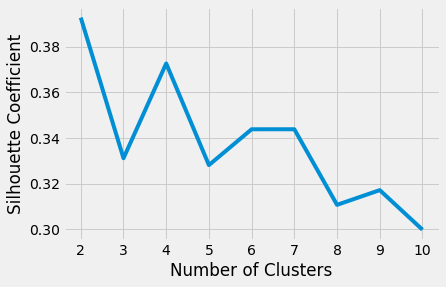

In [450]:
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

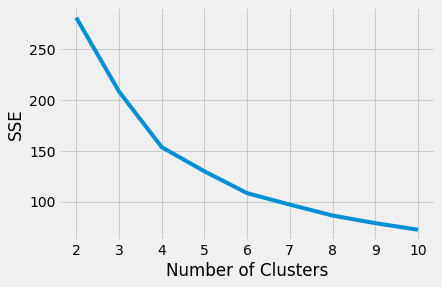

In [451]:
# ## Determine the elbow from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sseList)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [452]:
## Determine the elbow programmatically
kl = KneeLocator(
    range(2, 11), sseList, curve="convex", direction="decreasing"
)

kl.elbow

4

##### Assigning labels to each row

In [463]:
df_clustered = df_inliner.copy()
df_clustered['cluster'] = predicted_labels[1]

replace_map = {'cluster': {1: 'Loyal', 2: 'Quality', 0: 'Value'}}
df_clustered.replace(replace_map, inplace=True)

df_clustered = df_clustered.reset_index()
df_clustered.groupby('cluster')['CustomerID'].count()

cluster
Loyal      2585
Quality    1697
Value      1394
Name: CustomerID, dtype: int64

In [477]:
df_clustered.to_csv('clustered_data.csv')

### 2.3 Choosing the `K` and descriptives of each cluster

Although the evaluation metrics are in favor of `K=4`, a further look at the actual clusters shows that the additional cluster broke out from 3 clusters is too small and less distinvtive in terms of average % of spending in each price tiers. Therefore, I chose `K=3` for the final model.

In [478]:
## Load labeled data from github
url2 = 'https://raw.githubusercontent.com/Michael-Zh/DAassignment4IK/main/clustered_data.csv'

df_clustered = pd.read_csv(url2,sep = ',')

df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5676 entries, 0 to 5675
Columns: 252 entries, Unnamed: 0 to cluster
dtypes: float64(3), int64(243), object(6)
memory usage: 10.9+ MB


In [479]:
for col in ['Sex','Age','Profession','CityType','YearsInCity','HaveChildren','cluster','ValueTier']:
    df_clustered[col] = df_clustered[col].astype('category').cat.as_ordered()

##### **Naming the clusters**
The table below represent the average % of spending in each price tier product within each clusters.

* We can easily spot the exceptional high % in high price product - this signify the `Quality` cluster, who tends to purchase quality/expensive items most of the time

* We can also notice another high % in spending in mid-price product, while % of the high price products is the lowest - I named it `Value` to match their potential motivation of bargin seeking

* Lastly, the `Loyal` cluster sits in the middle - they seem to be happy with IKEA overall and purchase both bargin and higher price products

In [480]:
df_seg = df_clustered.groupby('cluster')['HighPerc','MidPerc','LowPerc'].mean()*100
df_seg.sort_values(by=['HighPerc','MidPerc','LowPerc']).sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,HighPerc,MidPerc,LowPerc
cluster,,,
Loyal,55.891021,38.246636,5.862342
Quality,77.945115,18.934045,3.120840
Value,33.763803,60.343782,5.892415


##### **Which cluster/segment to target?**
The two tables below shows the unique customer count in each cluster and value tiers, as well as their total spending in millions.

* Generally speaking, building the brand loyalty and design new products for distinct consumer require relatively long-term effort. Therefore, moving consumer from `Value` or `Quality` to `Loyal` may take a while.

* Meanwhile, a handful of short-term levers such as promotion, can potentially upsell lower value tier consumers and move them to higher tiers.

* In addition, if we assume they remain the same purchase pattern, namely purchase primarily high price point porducts, `Quality` cluster may offer higher incremental growth potential - even though it's not the highest valued segment (compared to all segments from `Loyal`).

* In conclusion, I recommend focusing on `Mid`/`Low` value tier customers in `Quality` cluster. 

In [481]:
## customer counts in each cluster
cnt_grid = df_clustered.groupby(['cluster','ValueTier'])['CustomerID'].count().reset_index()
cnt_grid = pd.DataFrame(cnt_grid)
for col in ['cluster','ValueTier']:
    cnt_grid[col] = cnt_grid[col].astype('str')

cnt_grid = pd.pivot_table(cnt_grid, values=['CustomerID'], index=['cluster'],\
                          columns=['ValueTier'], aggfunc=np.sum, fill_value=0)\
                          .droplevel(0, axis=1).sort_index()
cnt_grid[['High', 'Mid', 'Low']]

ValueTier,High,Mid,Low
cluster,,,
Loyal,874,747,963
Quality,175,621,901
Value,79,343,972


In [482]:
## toal seg value in each seg (M)
val_grid = df_clustered.groupby(['cluster','ValueTier'])['TotalSpending'].sum().reset_index()
val_grid = pd.DataFrame(val_grid)
for col in ['cluster','ValueTier']:
    val_grid[col] = val_grid[col].astype('str')

val_grid = pd.pivot_table(val_grid, values=['TotalSpending'], index=['cluster'],\
                          columns=['ValueTier'], aggfunc=np.sum, fill_value=0)\
                          .droplevel(0, axis=1)
val_grid[['High', 'Mid', 'Low']]/1000000

ValueTier,High,Mid,Low
cluster,,,
Loyal,2192.787474,641.213583,258.616132
Quality,307.162367,510.226155,247.668344
Value,141.282847,277.515329,224.596531


##### **Demographics**

Below demographic breakdowns can help facilitate tactical level marketing efforts. For example, `Value` cluster consists of much higher % of female customers (particularly among the high value tier). An in season home decoration collection or promotion may attract them to shop more. The `Quality` cluster shows a higher % in `36-45` age group, particularly among low- and high-valued segments, we may offer a campaign focus on the quality and design aspect of the product with an extra push of promotion.

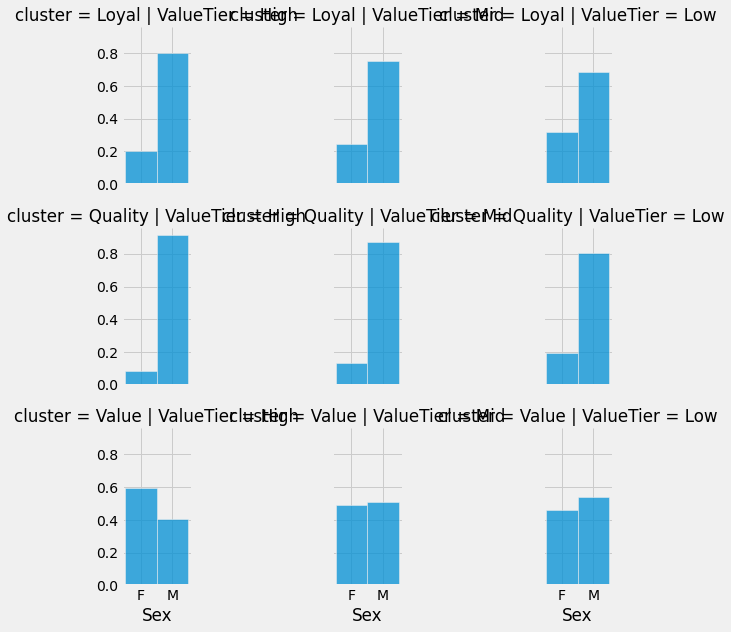

In [499]:
g0 = sns.FacetGrid(df_clustered, col='ValueTier', row="cluster", col_order=['High','Mid','Low'])
g0.map(sns.histplot,'Sex',stat="density", common_norm=False)
# g1.fig

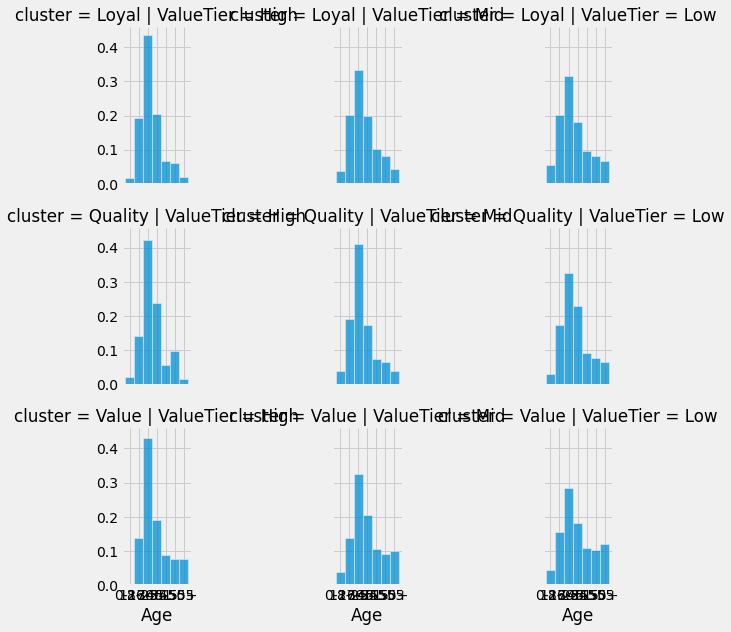

In [495]:
g3 = sns.FacetGrid(df_clustered, col='ValueTier', row="cluster", col_order=['High','Mid','Low'])
g3.map(sns.histplot,'Age',stat="density", common_norm=False)
# g3.fig

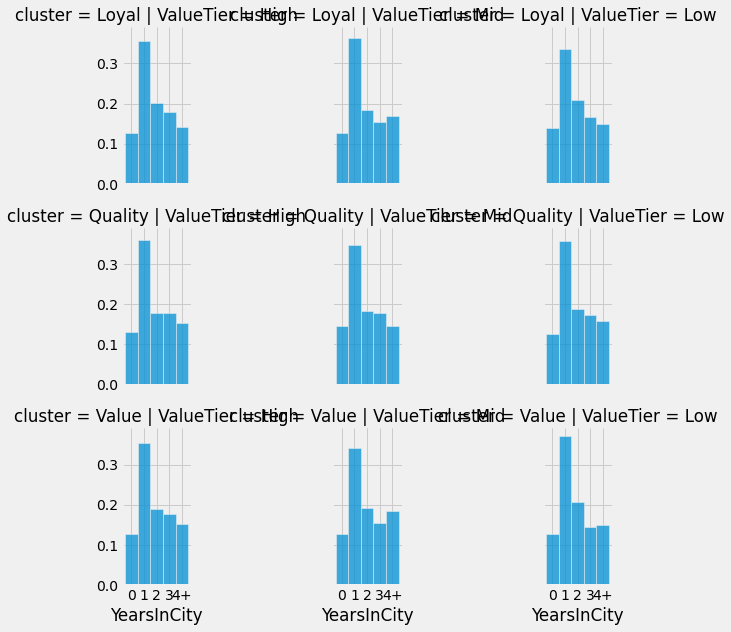

In [496]:
g4 = sns.FacetGrid(df_clustered, col='ValueTier', row="cluster", col_order=['High','Mid','Low'])
g4.map(sns.histplot,'YearsInCity',stat="density", common_norm=False)
# g3.fig